output shape of multihead attention:torch.Size([2, 4, 100])
shape of attention_weights:torch.Size([10, 4, 6])


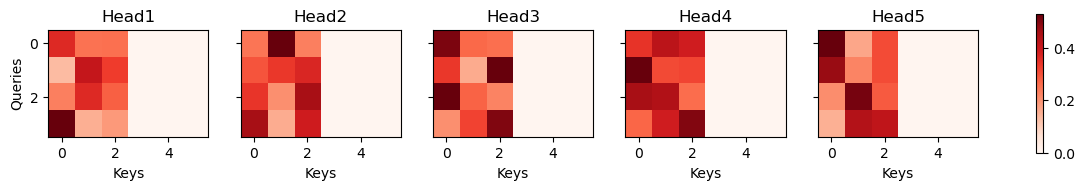

In [2]:
import torch, utils
from attention_functions import ScaledDotProductAttention
from torch import nn
class MultiHeadAttention(nn.Module):
    def __init__(self, query_size, key_size, value_size, num_hiddens,
                 num_heads, dropout, use_bias=False, **kwargs):
        super().__init__(**kwargs)
        self.num_heads = num_heads
        self.attention_function = ScaledDotProductAttention(dropout=dropout)
        self.W_qh = nn.Linear(query_size, num_hiddens, bias=use_bias)
        self.W_kh = nn.Linear(key_size, num_hiddens, bias=use_bias)
        self.W_vh = nn.Linear(value_size, num_hiddens, bias=use_bias)
        self.W_out = nn.Linear(num_hiddens, num_hiddens, bias=use_bias)

    def forward(self, queries, keys, values, valid_lens):
        """
        queries, keys, values的形状: (batch_size, 查询或者“键－值”对的个数, query_size或key_size或value_size)
        valid_lens的形状: (batch_size, )或(batch_size, 查询的个数)
        """
        # 经过变换后, 输出的queries, keys, values　的形状:
        # (batch_size*num_heads, 查询或者“键－值”对的个数, num_hiddens/num_heads)
        queries = self.transpose_qkv(self.W_qh(queries), self.num_heads)
        keys = self.transpose_qkv(self.W_kh(keys), self.num_heads)
        values = self.transpose_qkv(self.W_vh(values), self.num_heads)
        if valid_lens is not None:
            # 在轴0, 将第一项（标量或者矢量）复制num_heads次, 
            # 然后如此复制第二项, 然后诸如此类。
            valid_lens = torch.repeat_interleave(valid_lens, repeats=self.num_heads, dim=0)
        # output的形状:(batch_size*num_heads, 查询的个数, num_hiddens/num_heads)
        output = self.attention_function(queries, keys, values, valid_lens)
        # output_concat的形状:(batch_size, 查询的个数, num_hiddens)
        output_concat = self.transpose_output(output, self.num_heads)
        return self.W_out(output_concat)

    def transpose_qkv(self, X, num_heads):
        """
        为了多注意力头的并行计算而变换形状
        输入X的形状:(batch_size, 查询或者“键－值”对的个数, num_hiddens)
        """
        # 输出X的形状:(batch_size, 查询或者“键－值”对的个数, num_heads, num_hiddens/num_heads)
        X = X.reshape(X.shape[0], X.shape[1], num_heads, -1) # 为每个注意力头分配隐藏单元
        # 输出X的形状:(batch_size, num_heads, 查询或者“键－值”对的个数, num_hiddens/num_heads)
        X = X.permute(0, 2, 1, 3) # 为能在每个头上并行计算更改形状
        # 最终输出的形状:(batch_size*num_heads, 查询或者“键－值”对的个数, num_hiddens/num_heads)
        return X.reshape(-1, X.shape[2], X.shape[3])
    
    def transpose_output(self, X, num_heads):
        """逆转transpose_qkv函数的操作, 将多个注意力头结合成一个tensor"""
        X = X.reshape(-1, num_heads, X.shape[1], X.shape[2]) # 分离num_heads和batch_size维度
        X = X.permute(0, 2, 1, 3) # 调换num_heads和查询或“键－值”对的维度
        return X.reshape(X.shape[0], X.shape[1], -1) # 结合注意力头

num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens, num_hiddens, num_heads, 0.5)
attention.eval()
batch_size, num_queries = 2, 4
num_kvpairs, valid_lens = 6, torch.tensor([3, 2])
X = torch.randn((batch_size, num_queries, num_hiddens))
Y = torch.randn((batch_size, num_kvpairs, num_hiddens))
print(f"output shape of multihead attention:{attention(X, Y, Y, valid_lens).shape}")# 多头注意力输出的形状为(batch_size, num_queries, num_hiddens)
attention_weights = attention.attention_function.attention_weights
print(f"shape of attention_weights:{attention_weights.shape}") # 注意力权重的形状为(batch_size*num_heads, num_queries, num_kvpairs)
attention_weights = attention_weights.view(batch_size, num_heads, num_queries, num_kvpairs)
sample_attention_weight = attention_weights[0]
utils.show_heatmaps(
                    matrices=sample_attention_weight.unsqueeze(0),
                    xlabel='Keys',
                    ylabel='Queries',
                    titles=[f"Head{i+1}" for i in range(num_heads)],
                    figsize=(num_heads*3, 3)
                    )

### 在多头注意力中的张量形状改变
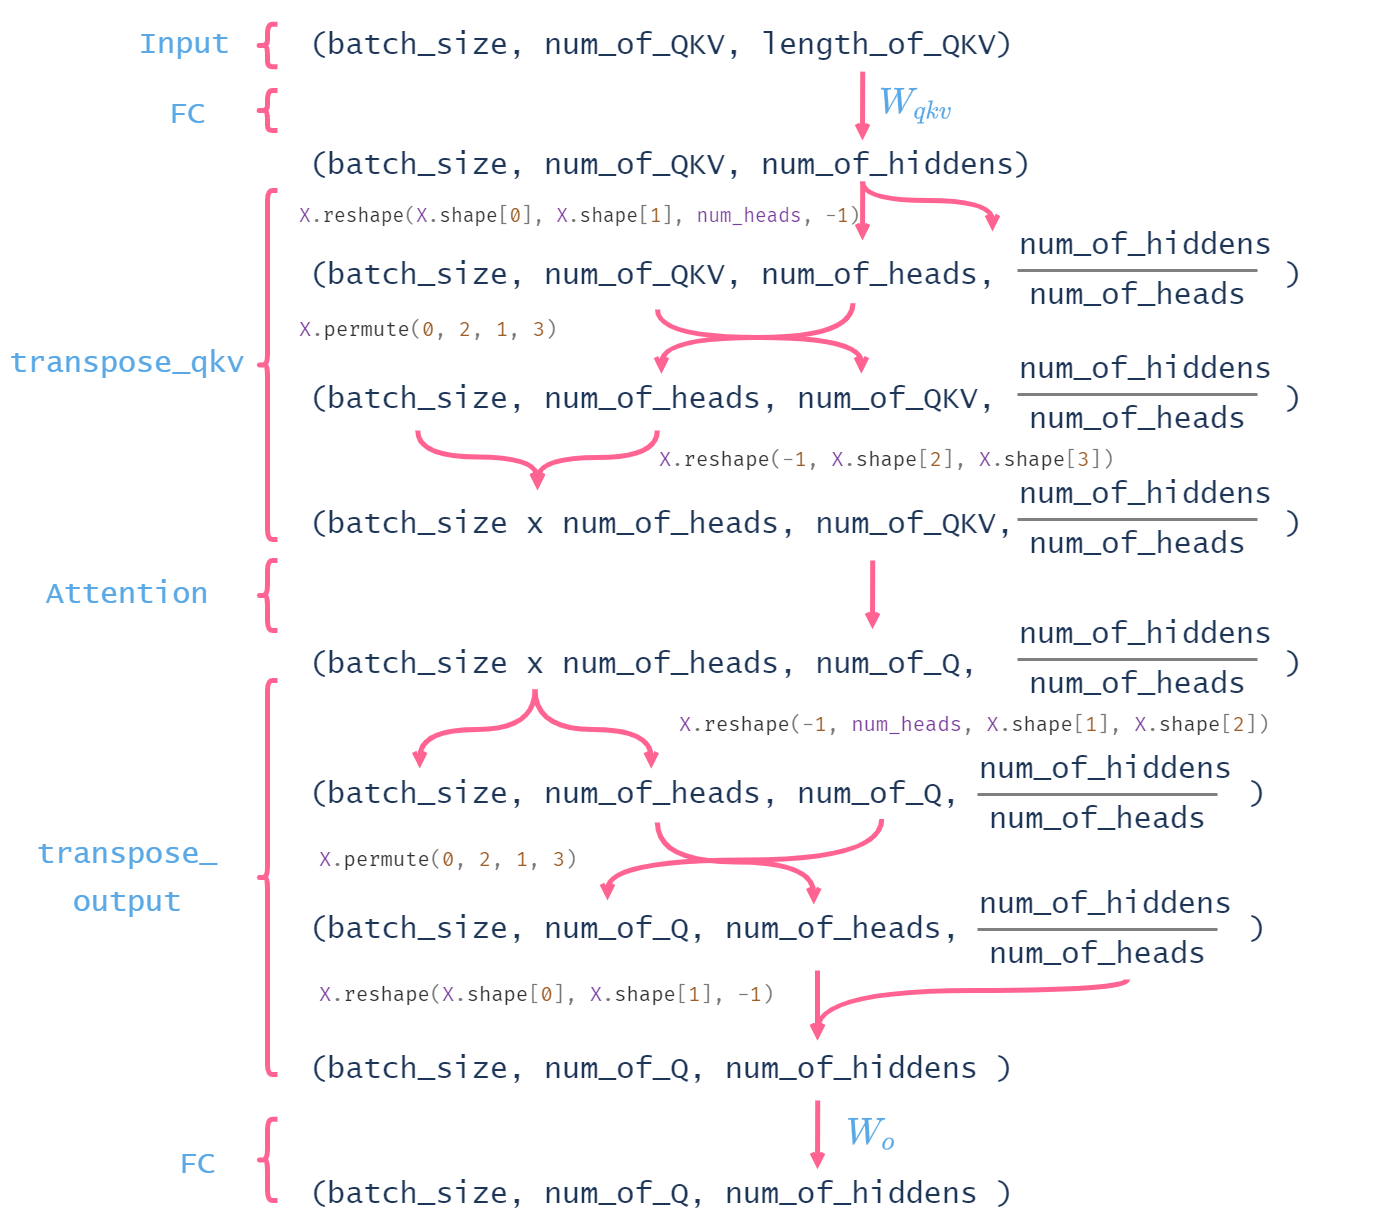

Attention Output Shape: torch.Size([10, 32, 64])
Attention Weights Shape: torch.Size([32, 4, 10, 10])


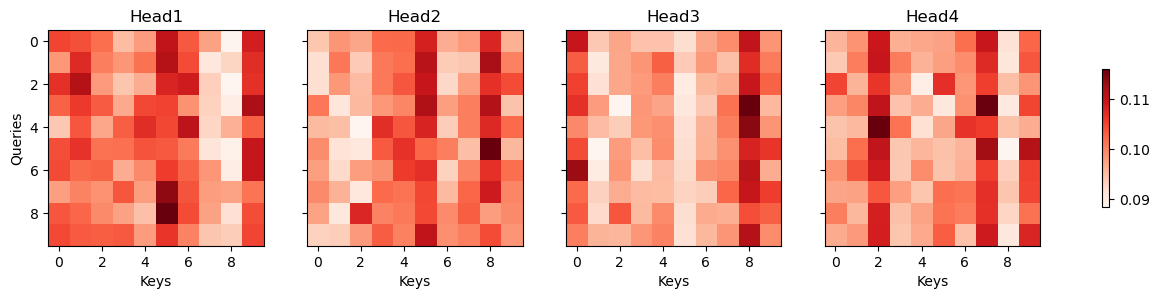

In [4]:
embed_dim = 64
num_heads = 4
batch_size, seq_lens = 32, 10
attention = nn.MultiheadAttention(embed_dim=64, num_heads=num_heads, dropout=0.3)
attention.eval()

query = torch.rand(seq_lens, batch_size, embed_dim)
key = torch.rand(seq_lens, batch_size, embed_dim)
value = torch.rand(seq_lens, batch_size, embed_dim)

# Pytorch的MultiheadAttention默认返回所有注意力头相加后取平均的注意力权重，如果希望得到每个头的注意力权重，可以将average_attn_weights参数设为False。
attention_output, attention_output_weights = attention(query, key, value, average_attn_weights=False)
print("Attention Output Shape:", attention_output.shape) # shape=(seq_len, batch_size, embed_size)
print("Attention Weights Shape:", attention_output_weights.shape) # shape=(batch_size, num_heads, seq_len(num_queries), seq_len(num_kvpairs))
sample_attention_weight = attention_output_weights[0]
utils.show_heatmaps(
                    matrices=sample_attention_weight.unsqueeze(0),
                    xlabel='Keys',
                    ylabel='Queries',
                    titles=[f"Head{i+1}" for i in range(num_heads)],
                    figsize=(num_heads*4, 3)
                    )

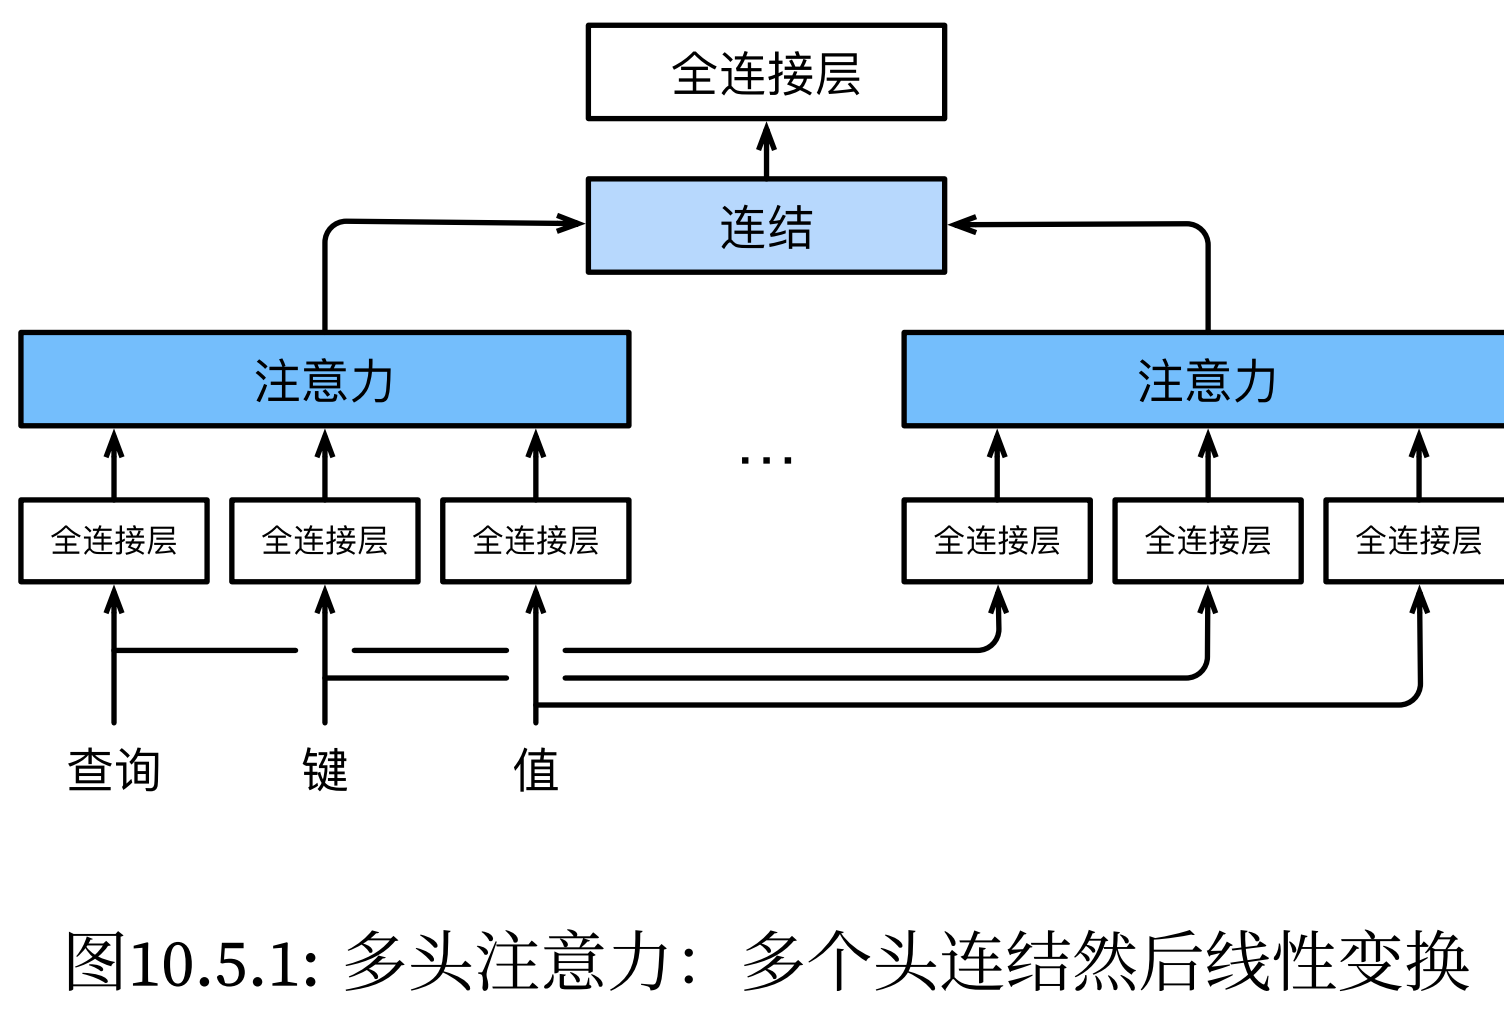